In [1]:
from utils.config import Config

from collections import OrderedDict

from glob import glob 
import os
import pandas as pd 
import numpy as np 
import mne
import seaborn as sns 
sns.set(font_scale=1)
import matplotlib.pyplot as plt 
%matplotlib notebook

from pyxdf import load_xdf

print("Config LOADED")

Config LOADED


# Kick-Off Notebook for rASR implementation 

This notebook is a very crude and straightforward dive into the data provided by Sarah Blum on rASR. It's main purpose is to share with you some useful functions I have already, so that you save some time. 
It consists in: 
- loading the eeg signal (and events?) from the *xdf* and *set* files
- visualizing the power spectral density (check dead channels and line noise) 
- apply a IIR filter using either timeflux node or mne functions 
- apply a rolling window and apply any method from a sklearn estimator 
- leave implementation of rASR as in a sklearn estimator as a TODO thing 
- go back to pandas and plot the pre/post signal  

## Raw data 

### Load xdf and extract eeg stream

In [2]:
k_file = 0

from utils.utils import get_stream_names, extract_signal_stream
raw_xdf_fname = Config.raw_files[k_file]
streams, _ = load_xdf(raw_xdf_fname)
stream_names = get_stream_names(streams)
df_eeg_raw = extract_signal_stream(streams , 'Android_EEG_010026')
df_presentation_events = extract_signal_stream(streams , 'Presentation_Markers')
print(df_eeg_raw.head())

print("RAW EEG LOADED")

                      Fp1           Fp2           Fz           F7  \
7497.971543 -16967.007812 -10655.322266 -3959.700928 -9417.929688   
7497.975543 -16968.863281 -10659.859375 -3959.589111 -9420.388672   
7497.979543 -16965.845703 -10649.287109 -3960.550293 -9420.678711   
7497.983543 -16963.566406 -10633.461914 -3960.192627 -9420.723633   
7497.987543 -16962.447266 -10647.767578 -3959.410400 -9419.717773   

                       F8          FC1          FC2           Cz  \
7497.971543 -17009.855469 -8716.822266 -9959.065430 -7430.814453   
7497.975543 -16994.410156 -8719.572266 -9956.942383 -7431.909668   
7497.979543 -17014.058594 -8720.756836 -9957.612305 -7431.887695   
7497.983543 -17007.039062 -8721.717773 -9957.679688 -7431.529785   
7497.987543 -17000.490234 -8722.142578 -9958.082031 -7432.133301   

                       C3           C4  ...           O1           O2  GyroX  \
7497.971543 -15642.242188 -8289.144531  ... -6697.856445 -4115.246582   0.49   
7497.975543 -156

In [3]:
# select EEG channels 
eeg_columns = ['Fp1', 'Fp2', 'Fz', 'F7', 'F8', 'FC1', 'FC2', 'Cz', 'C3', 'C4', 'T7',
       'T8', 'CPz', 'CP1', 'CP2', 'CP5', 'CP6', 'Tp9', 'Tp10', 'Pz', 'P3',
       'P4', 'O1', 'O2']
df_eeg_raw = df_eeg_raw.loc[:, eeg_columns]

print("EEG channels selected")

EEG channels selected


### Convert float index in datetime, estimate duration/srate
- convert float index in datetime
- estimate duration/srate

In [4]:
from utils.utils import float_index_to_time_index
from utils.utils import estimate_rate


df_eeg_raw = float_index_to_time_index(df_eeg_raw)

duration = (df_eeg_raw.index[-1] - df_eeg_raw.index[0]).total_seconds()/60
rate = estimate_rate(df_eeg_raw)

print(f'Duration of session was {duration} min. \n '+ 
     f'Rate is of {rate} Hz.')

Duration of session was 21.5832569 min. 
 Rate is of 250.0 Hz.


### Convert from pandas to mne, and eventually filter using timeflux or mne 

In [5]:
from utils.utils import pandas_to_mne
#df_eeg_raw = pd.read_hdf(fname, '/eeg/raw') # TODO: adapt hdf5 groups 
# df_events = pd.read_hdf(fname, '/events/speller') # TODO: adapt hdf5 groups 
# baseline_events = df_events[df_events.label.str.contains('baseline')] # TODO: adapt calib times 
# calib_times = baseline_events.index[0], baseline_events.index[-1] # TODO: adapt calib times 


bad_ch = []

mne_eeg_raw, mene_event_id, mne_picks = pandas_to_mne(df_eeg_raw, rate=rate, bad_ch=bad_ch)

# Either filter using mne offline tool (higher order)
# ----------------------------------------------------
mne_eeg_filtered = mne_eeg_raw.copy().filter(1, 30)
df_eeg_filtered = pd.DataFrame(mne_eeg_filtered.to_data_frame().values, 
                               df_eeg_raw.index, df_eeg_raw.columns)


# Or mimick online with timeflux
# ------------------------------
# notch + bandpass in realtime world 
#=======================================================================#
#======= UNCOMMENT THESE LINES TO DO SO ================================#
#from timeflux_dsp.nodes.filters import IIRFilter, IIRLineFilter
## apply a line noise filter
#line = IIRLineFilter(rate=rate, edges_center=(50, 100))
#line.i.data = df_eeg_raw
#line.update()
## apply a bandpass filter 
#bandpass = IIRFilter(rate=rate, order=3, frequencies=[1, 30], filter_type='bandpass')
#bandpass.i.data = line.o.data
#bandpass.update()
# convert dataframe to mne 
#df_eeg_filtered, _, _ = pandas_to_mne(bandpass.o.data, sfreq=rate, bad_ch=bad_ch)
#=======================================================================#

/Users/louis/anaconda3/envs/timeflux_rasr-env/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/Users/louis/anaconda3/envs/timeflux_rasr-env/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/Ext/git/timeflux_rasr/utils/utils.py:173: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an e

Converting "time" to "<class 'numpy.int64'>"...


### Visualize power spectral density

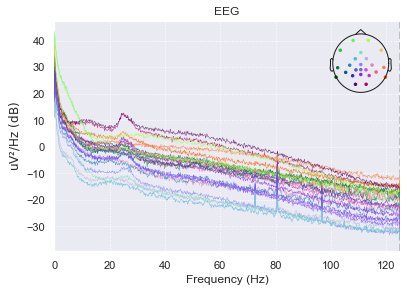

<Figure size 432x288 with 0 Axes>

In [6]:
mne_eeg_raw.plot_psd(); 
plt.suptitle('Raw'); 

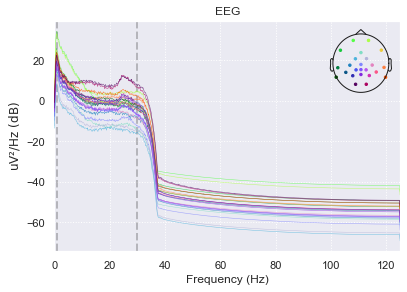

<Figure size 432x288 with 0 Axes>

In [7]:
mne_eeg_filtered.plot_psd(); 
plt.suptitle('Filtered'); 

## Load filtered data 

Reading /Users/louis/AlayaTec Dropbox/louis korczowski/rASR Data/filtered/sme_1_5.xdf_filt.fdt
Converting "time" to "<class 'numpy.int64'>"...
Effective window size : 8.192 (s)


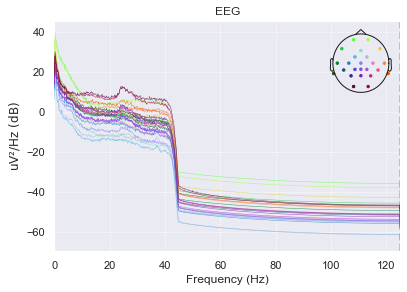

In [8]:
from mne.io import read_raw_eeglab
mne_eeg_filtered =  read_raw_eeglab(Config.filtered_files[k_file])
df_eeg_filtered = mne_eeg_filtered.to_data_frame()
mne_eeg_filtered.plot_psd(); 

# Load calibration data 


Reading /Users/louis/AlayaTec Dropbox/louis korczowski/rASR Data/calibration data/sme_1_5.xdf_filt.fdt
Converting "time" to "<class 'numpy.int64'>"...


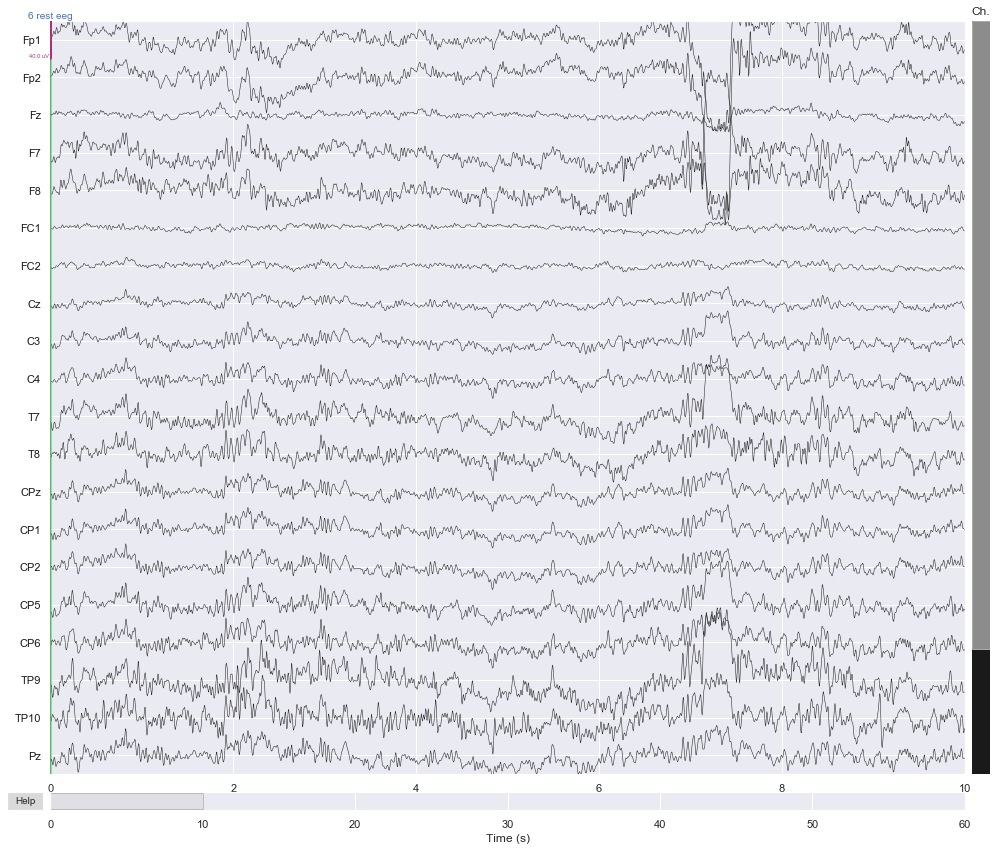

In [9]:
mne_eeg_calibration =  read_raw_eeglab(Config.calibration_files[k_file])
df_eeg_calibration = mne_eeg_calibration.to_data_frame()
mne_eeg_calibration.plot(); 

# Load rASR output 


Reading /Users/louis/AlayaTec Dropbox/louis korczowski/rASR Data/Riemannian ASR out/sme_1_3.fdt


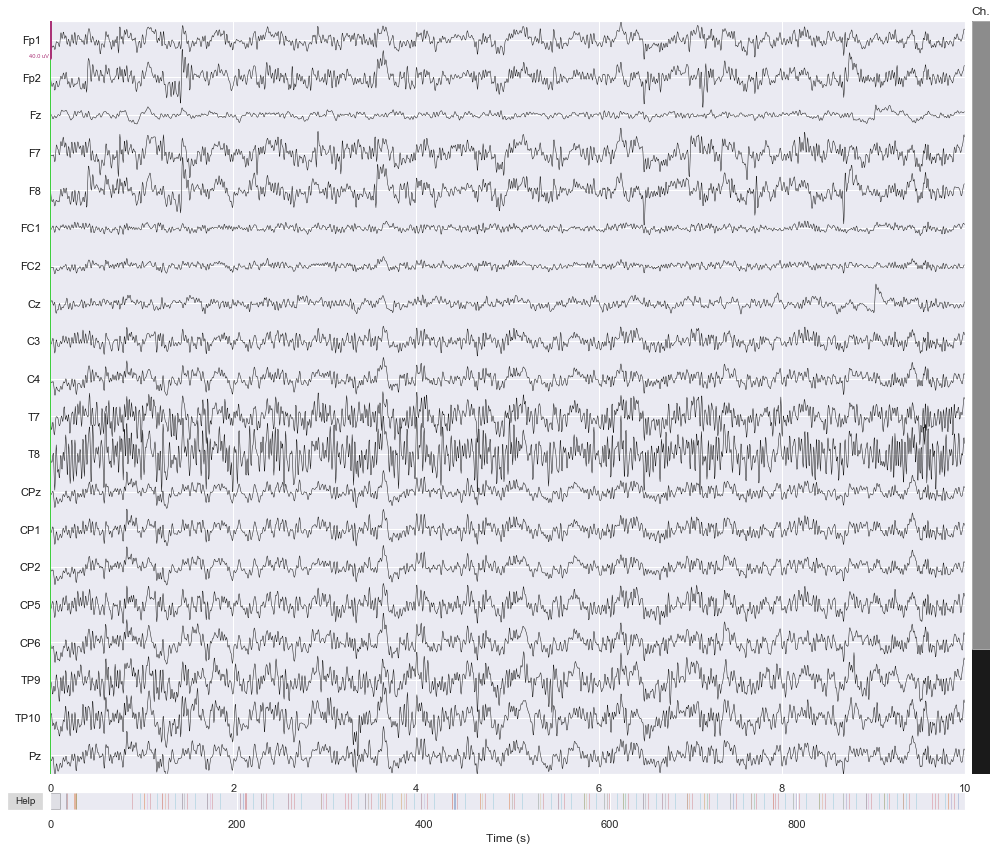

In [10]:
mne_eeg_cleaned =  read_raw_eeglab(Config.riemannian_asr_out_files[k_file])
mne_eeg_cleaned.plot(); 

In [11]:
df_eeg_cleaned = mne_eeg_cleaned.to_data_frame()
df_eeg_cleaned.head()

Converting "time" to "<class 'numpy.int64'>"...


channel,Fp1,Fp2,Fz,F7,F8,FC1,FC2,Cz,C3,C4,...,CP2,CP5,CP6,TP9,TP10,Pz,P3,P4,O1,O2
time,,,,,,,,,,,,,,,,,,,,,
0,-0.013201,-0.018014,-0.002674,-0.014927,-0.020207,-0.004922,-0.005249,0.003866,-0.008218,-0.009376,...,-0.003169,-0.008527,-0.006787,-0.013160,-0.009481,-0.006543,-0.009023,-0.005224,-0.011545,-0.005085
4,-2.149520,-2.997436,0.370554,-2.383737,-3.500363,-0.985134,-1.113579,1.089316,-2.378617,-2.461724,...,-2.277262,-3.182305,-2.891909,-1.720168,2.490218,-3.319987,-3.407804,-3.142468,-4.570573,-4.117846
8,-3.895139,-5.864177,0.539733,-3.178975,-6.947680,-1.263157,-1.854852,2.028313,-3.210253,-4.013163,...,-3.846894,-4.019107,-5.053304,-2.674080,4.502221,-5.507792,-4.718487,-5.463203,-5.167932,-7.430803
12,-5.326047,-8.181021,0.234812,-2.908594,-9.845233,-0.794303,-2.190716,2.798930,-2.408971,-4.549795,...,-4.462390,-2.443428,-6.368649,-4.445235,3.826417,-5.994227,-3.425189,-6.924243,-2.071115,-9.617757
16,-6.644497,-9.594512,-0.669602,-2.639865,-11.759719,0.153404,-2.224215,3.137824,-0.649834,-4.409935,...,-4.330470,0.285214,-6.976540,-8.078924,0.009132,-5.036457,-0.483622,-7.656090,2.468204,-10.303535


# Epoch the data

In [12]:
from utils.utils import epoch


In [13]:
size = int(rate*3) # size of window in samples 
interval = size # step interval in samples 

# convert filtered data into epochs 
np_eeg_filtered_epochs = epoch(df_eeg_filtered.values, size, interval, axis=0)# (n_channels,  n_times, n_trials)
print("shape test data")
print(np_eeg_filtered_epochs.shape)
#np_eeg_filtered_epochs = np.swapaxes(np_eeg_filtered_epochs, 0, 2 ) # (n_trials, n_channels, n_times)

# convert calibration data into epochs 
np_eeg_calibration_epochs = epoch(df_eeg_calibration.values, size, interval, axis=0)# (n_channels,  n_times, n_trials)
#np_eeg_calibration_epochs = np.swapaxes(np_eeg_calibration_epochs, 0, 2 )# (n_trials, n_channels, n_times)
print("shape training data")
print(np_eeg_calibration_epochs.shape)

shape test data
(426, 750, 24)
shape training data
(20, 750, 24)


## RASR IMPLEMENTATION 

In [14]:
# Let's say we calibrate on the 20 first epochs and test on the rest 
# TODO : refine this 
X_fit = np_eeg_calibration_epochs
X_test = np_eeg_filtered_epochs
print("copied epochs")

copied epochs


# RASR tests

In [15]:
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import Covariances
from pyriemann.channelselection import FlatChannelRemover
from timeflux_rasr.estimation import RASR
rASR_pipeline = make_pipeline(RASR())
print(X_fit.shape)
print(X_test.shape)
X_test_transformed = rASR_pipeline.fit(X_fit).transform(X_test)

(20, 750, 24)
(426, 750, 24)
epoching
geometric median
rASR calibrated
RASR.transform(): check input
RASR.transform(): compute covariances
RASR.transform(): clean each epoch


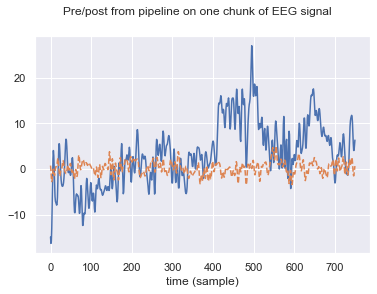

In [16]:
k_ch = 8
k_epoch = 10

plt.figure()
plt.plot(X_test[k_epoch,:,k_ch])
plt.plot(X_test_transformed[k_epoch,:,k_ch], '--')
plt.suptitle(f'Pre/post from pipeline on one chunk of EEG signal')
plt.xlabel('time (sample)')
plt.show()

## Back to signal 

In [21]:
values = X_test_transformed.reshape(-1, X_test_transformed.shape[-1])

(319500, 24)
319500
(319500, 24)


In [ ]:
df_eeg_cleaned_v2 = pd.DataFrame(values, columns = df_eeg_raw.columns)
df_eeg_cleaned_v2.head()